<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/IA353/EF2/Q6P1_NYSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IA353 - Redes Neurais
# EFC3 - Questão 6 - Parte 1

## Predição de séries temporais empregando vários tipos de modelos
#### Parcialmente baseado em https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
## Caso de estudo: Mercado de ações (NYSE: The New York Stock Exchange)
#### Parcialmente baseado em https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Samuel Borges Ferreira Gomes

### 6.1. Importações e definições

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat

# Specifi imports
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Steps")
    plt.ylabel("Time Series Values")
    plt.title("Sunspots Time Series")
    plt.grid(True)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


### 6.2. Carregando a base de dados e apresentando sua composição

In [2]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

# import all stock prices 
df = pd.read_csv("/content/prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['BWA', 'MA', 'R', 'GWW', 'EL', 'KSS', 'MRK', 'AMG', 'COP', 'FITB']


,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


### 6.3. Exibindo o comportamento temporal de várias séries associadas à ação EQIX

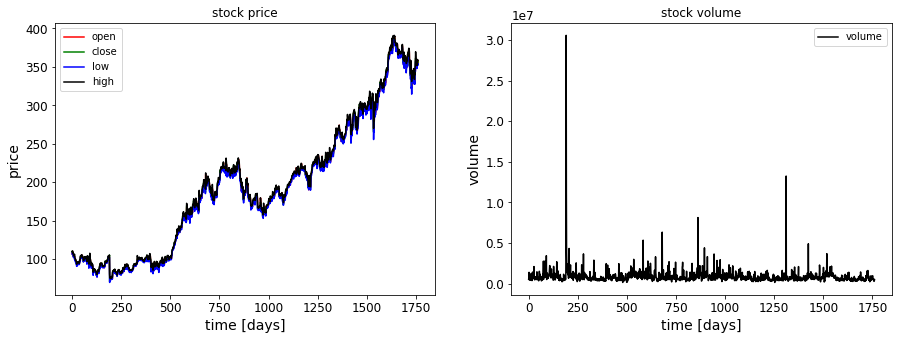

In [3]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

### 6.4. Escolha do preço de fechamento da ação EQIX e preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste
#### Cabe comentar que os dados de teste não deveriam participar de nenhuma etapa de pré-processamento, pois, assim, têm o potencial de interferir no andamento do treinamento, desvirtuando o seu papel de apenas servirem para teste de desempenho. Cometeremos essa "mancada" metodológica para despertar o(a) aluno(a) para a questão.

In [4]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = np.array(stock) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    # Choice of the close behavior
    
    x_train = data[:train_set_size,:-1,1]
    y_train = data[:train_set_size,-1,1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,1]
    
    x_test = data[train_set_size+valid_set_size:,:-1,1]
    y_test = data[train_set_size+valid_set_size:,-1,1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    np.savetxt('Q6P1_x_train.txt', x_train)
    np.savetxt('Q6P1_y_train.txt', y_train)
    np.savetxt('Q6P1_x_valid.txt', x_valid)
    np.savetxt('Q6P1_y_valid.txt', y_valid)
    np.savetxt('Q6P1_x_test.txt', x_test)
    np.savetxt('Q6P1_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
print('Chosen stock is EQIX')
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols[1])

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

Chosen stock is EQIX
df_stock.columns.values =  close
x_train.shape =  (1393, 20)
y_train.shape =  (1393, 1)
x_valid.shape =  (174, 20)
y_valid.shape =  (174, 1)
x_test.shape =  (174, 20)
y_test.shape =  (174, 1)


### 6.5. Visualização do comportamento da série temporal normalizada

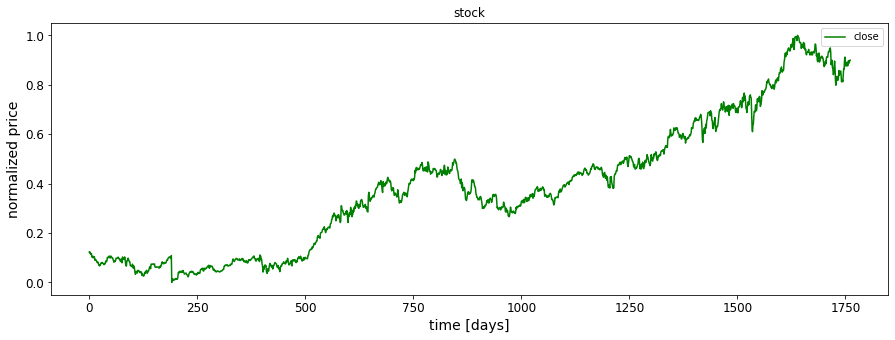

In [5]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.close.values, color='green', label='close')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')
plt.show()

### 6.6. Sintetizando um preditor linear

In [6]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = lr.coef_[0]
print('Coeficientes do preditor linear')
print(w)

Coeficientes do preditor linear
[-1.73993876e-02 -7.50066948e-04 -1.72042605e-02 -3.09133810e-03
  7.19680083e-02 -4.14608411e-02  6.27850574e-03  3.20712481e-02
 -5.12410805e-02 -4.49534424e-02  7.63970457e-02  2.38739465e-03
 -2.37630945e-02  4.03452307e-02  1.52671193e-03 -2.65006693e-02
  6.09614856e-02 -2.34004550e-02 -4.62112083e-03  9.62510603e-01
  0.00000000e+00]


#### 6.6.1. Visualização do desempenho do preditor linear

In [7]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Linear
8.2815338977819e-05
EQM final de validação após o término do treinamento - Preditor Linear
0.00027770088993386247
EQM final de teste após o término do treinamento - Preditor Linear
0.00021231229767131773


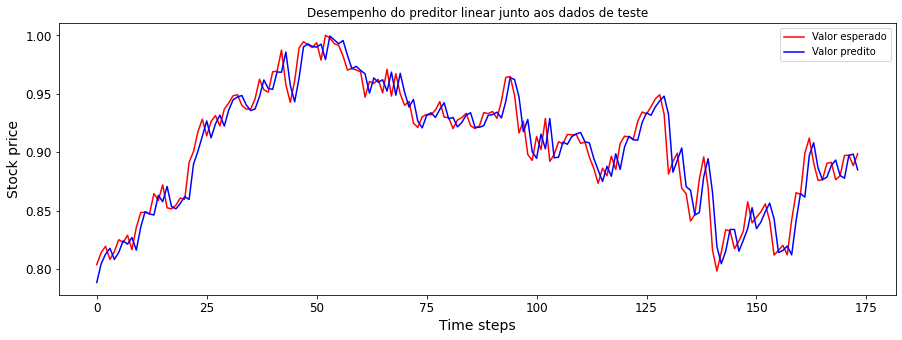

In [8]:
y_pred = X.dot(w)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.7. Sintetizando um preditor não-linear MLP

In [9]:
EPOCHS = 20
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer="adam")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Epoch 1/20
44/44 [==============================] - 1s 6ms/step - loss: 0.0141 - val_loss: 0.0176
Epoch 2/20
44/44 [==============================] - 0s 2ms/step - loss: 5.2880e-04 - val_loss: 0.0064
Epoch 3/20
44/44 [==============================] - 0s 3ms/step - loss: 3.6792e-04 - val_loss: 0.0036
Epoch 4/20
44/44 [==============================] - 0s 2ms/step - loss: 3.1558e-04 - val_loss: 0.0036
Epoch 5/20
44/44 [==============================] - 0s 2ms/step - loss: 2.8513e-04 - val_loss: 0.0028
Epoch 6/20
44/44 [==============================] - 0s 3ms/step - loss: 2.4944e-04 - val_loss: 0.0026
Epoch 7/20
44/44 [==============================] - 0s 2ms/step - loss: 2.2248e-04 - val_loss: 0.0015
Epoch 8/20
44/44 [==============================] - 0s 3ms/step - loss: 2.1365e-04 - val_loss: 0.0019
Epoch 9/20
44/44 [==============================] - 0s 2ms/step - loss: 1.7862e-04 - val_loss: 0.0011
Epoch 10/20
44/44 [==============================] - 0s 3ms/step - loss: 1.6850e-04 - 

In [10]:
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               2688      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________


#### 6.7.1. Carregando o modelo com o menor MAPE para o preditor MLP

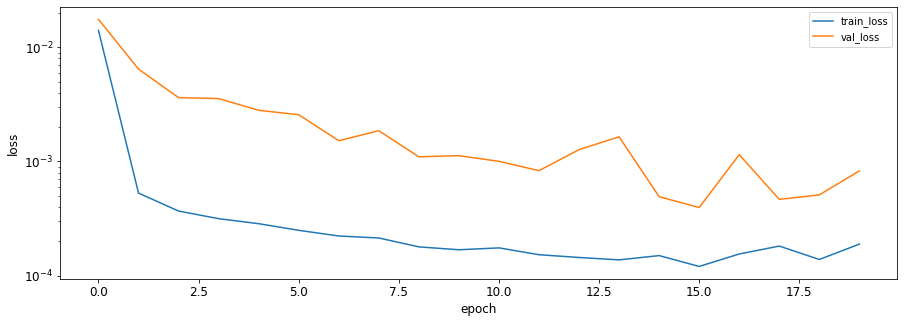

In [11]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.7.2. Visualização do desempenho do preditor MLP

In [12]:
#weights = model_MLP.get_weights()
#print(weights)
print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
0.0001212699405075525
EQM final de validação após o término do treinamento - Preditor MLP
0.0003949417404347375
EQM final de teste após o término do treinamento - Preditor MLP
0.0008925017451125632


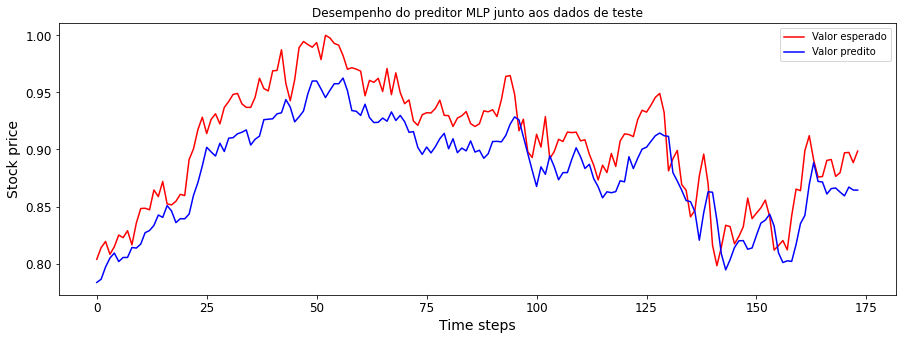

In [13]:
y_pred = model_MLP.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor MLP junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.8. Sintetizando um preditor não-linear Simple RNN

In [14]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model_RNN1.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN1_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN1.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(1393, 20, 1)
(1393, 1)
(174, 20, 1)
(174, 1)
(174, 20, 1)
(174, 1)
Epoch 1/20
44/44 [==============================] - 2s 16ms/step - loss: 0.0199 - val_loss: 0.0026
Epoch 2/20
44/44 [==============================] - 0s 10ms/step - loss: 9.8488e-04 - val_loss: 0.0025
Epoch 3/20
44/44 [==============================] - 0s 10ms/step - loss: 7.7301e-04 - val_loss: 0.0023
Epoch 4/20
44/44 [==============================] - 0s 11ms/step - loss: 7.1213e-04 - val_loss: 0.0030
Epoch 5/20
44/44 [==============================] - 0s 9ms/step - loss: 6.7540e-04 - val_loss: 0.0036
Epoch 6/20
44/44 [==============================] - 0s 9ms/step - loss: 6.3687e-04 - val_loss: 0.0025
Epoch 7/20
44/44 [==============================] - 0s 9ms/step - loss: 6.0070e-04 - val_loss: 0.0026
Epoch 8/20
44/44 [==============================] - 0s 9ms/step - loss: 5.5675e-04 - val_loss: 0.0024
Epoch 9/20
44/44 [==============================] - 0s 9ms/step - loss: 5.2492e-04 - val_loss: 0.0022
Epoch 10/20
44

In [15]:
model_RNN1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


#### 6.8.1. Carregando o modelo com o menor MAPE para o preditor não-linear Simple RNN

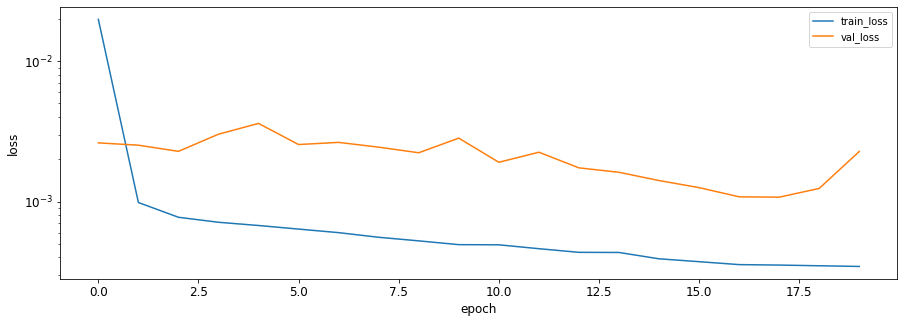

In [16]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN1.load_weights("model_RNN1_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.8.2. Visualização do desempenho do preditor não-linear Simple RNN junto aos dados de teste

In [17]:
print('EQM final de treinamento após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Simple RNN
0.0003596431250981324
EQM final de validação após o término do treinamento - Preditor Simple RNN
0.0010747942365016787
EQM final de teste após o término do treinamento - Preditor Simple RNN
0.00669513582964338


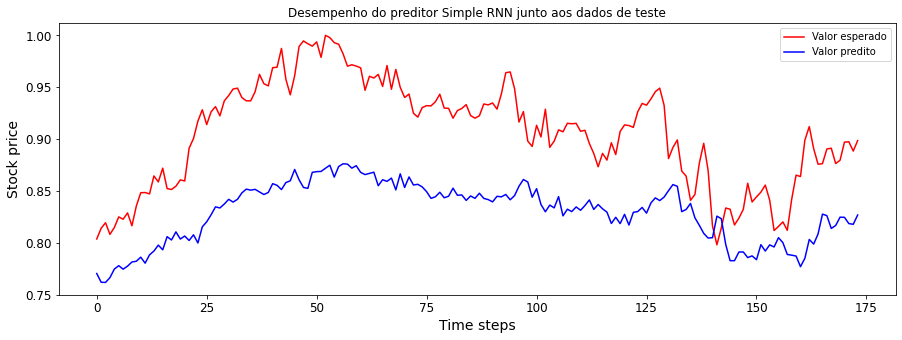

In [18]:
y_pred = model_RNN1.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor Simple RNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.9. Sintetizando um preditor não-linear com bloco LSTM GRU

In [19]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN2 = keras.models.Sequential([
    keras.layers.GRU(seq_len, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(seq_len, return_sequences=True),
    keras.layers.Dense(1)
])

model_RNN2.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN2_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN2.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(1393, 20, 1)
(1393, 1)
(174, 20, 1)
(174, 1)
(174, 20, 1)
(174, 1)
Epoch 1/20
44/44 [==============================] - 5s 37ms/step - loss: 0.0202 - val_loss: 0.0465
Epoch 2/20
44/44 [==============================] - 1s 21ms/step - loss: 0.0063 - val_loss: 0.0227
Epoch 3/20
44/44 [==============================] - 1s 22ms/step - loss: 0.0037 - val_loss: 0.0146
Epoch 4/20
44/44 [==============================] - 1s 21ms/step - loss: 0.0024 - val_loss: 0.0093
Epoch 5/20
44/44 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0073
Epoch 6/20
44/44 [==============================] - 1s 20ms/step - loss: 0.0016 - val_loss: 0.0061
Epoch 7/20
44/44 [==============================] - 1s 21ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 8/20
44/44 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 9/20
44/44 [==============================] - 1s 23ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 10/20
44/44 [======================

In [20]:
model_RNN2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           21        
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
_________________________________________________________________


#### 6.9.1. Carregando o modelo com o menor MAPE para o preditor não-linear com bloco LSTM GRU

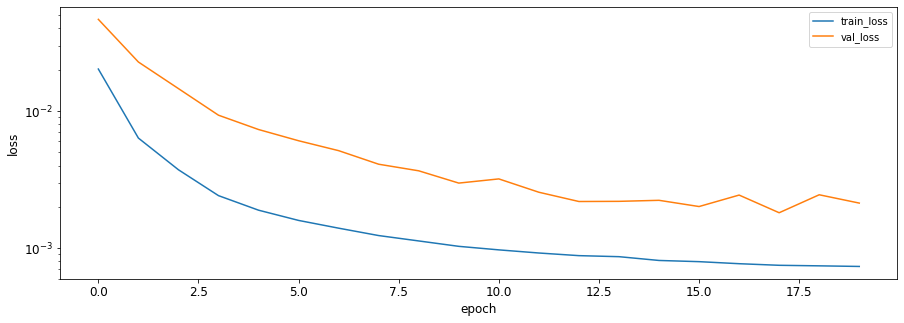

In [21]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN2.load_weights("model_RNN2_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.9.2. Visualização do desempenho do preditor não-linear com bloco LSTM GRU junto aos dados de teste

In [22]:
print('EQM final de treinamento após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_train,y_train)
print('EQM final de validação após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_valid,y_valid)
print('EQM final de teste após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_test,y_test)

EQM final de treinamento após o término do treinamento - Preditor LSTM GRU
44/44 [==============================] - 0s 5ms/step - loss: 7.5924e-04
EQM final de validação após o término do treinamento - Preditor LSTM GRU
6/6 [==============================] - 0s 6ms/step - loss: 0.0018
EQM final de teste após o término do treinamento - Preditor LSTM GRU
6/6 [==============================] - 0s 7ms/step - loss: 0.0019


0.0019320899154990911

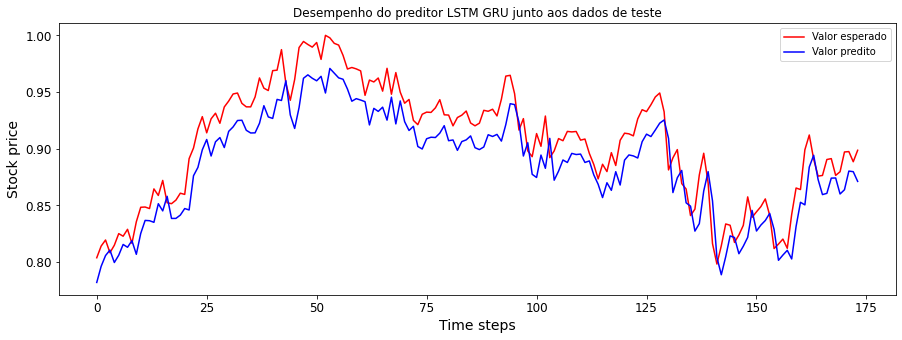

In [23]:
y_pred = model_RNN2.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred[:,seq_len - 1], color='blue', label='Valor predito')
plt.title('Desempenho do preditor LSTM GRU junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.10. Sintetizando um preditor não-linear CNN 1D
#### Parcialmente baseado em https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/1_CNN_dilated.ipynb

In [24]:
from keras.layers import Conv1D, Dense, Flatten
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
model_CNN = Sequential()
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(seq_len, 1)))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(1, activation='linear'))
model_CNN.compile(optimizer='Adam', loss='mse')

In [25]:
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 5)             15        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 5)             55        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 5)             55        
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


In [26]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_CNN_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_CNN.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/20
44/44 [==============================] - 17s 16ms/step - loss: 0.0417 - val_loss: 0.0263
Epoch 2/20
44/44 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 3/20
44/44 [==============================] - 0s 3ms/step - loss: 7.5162e-04 - val_loss: 0.0012
Epoch 4/20
44/44 [==============================] - 0s 3ms/step - loss: 4.7407e-04 - val_loss: 0.0011
Epoch 5/20
44/44 [==============================] - 0s 3ms/step - loss: 4.6875e-04 - val_loss: 0.0011
Epoch 6/20
44/44 [==============================] - 0s 3ms/step - loss: 4.2361e-04 - val_loss: 0.0011
Epoch 7/20
44/44 [==============================] - 0s 3ms/step - loss: 4.5678e-04 - val_loss: 0.0011
Epoch 8/20
44/44 [==============================] - 0s 4ms/step - loss: 4.2591e-04 - val_loss: 0.0011
Epoch 9/20
44/44 [==============================] - 0s 4ms/step - loss: 4.5102e-04 - val_loss: 0.0011
Epoch 10/20
44/44 [==============================] - 0s 3ms/step - loss: 4.3912e-04 - va

#### 6.10.1. Carregando o modelo com o menor MAPE para o preditor CNN

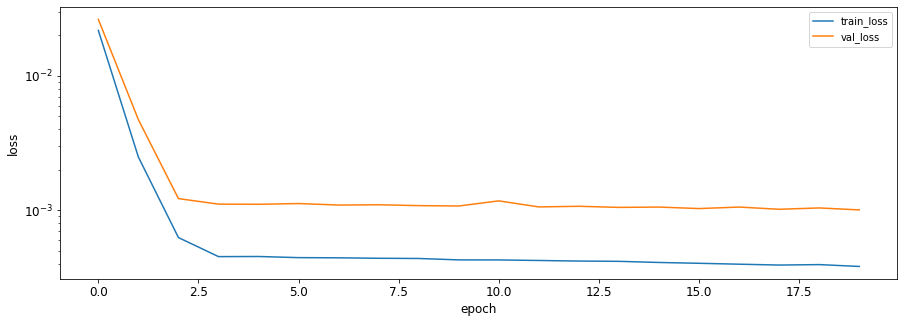

In [27]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_CNN.load_weights("model_CNN_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.10.2. Visualização do desempenho do preditor CNN junto aos dados de teste

In [28]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
0.00037786134766922225
EQM final de validação após o término do treinamento - Preditor CNN
0.0010035880770976457
EQM final de teste após o término do treinamento - Preditor CNN
0.0009092662623660494


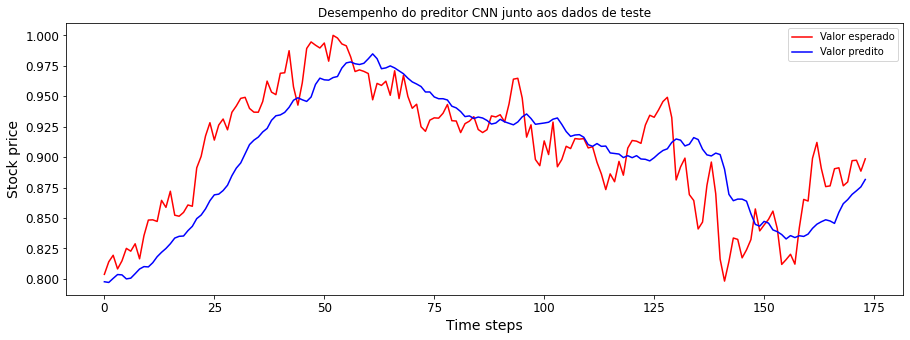

In [29]:
y_pred = model_CNN.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor CNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

## Resultados

### 6.1.1

#### O objetivo desse notebook é comparar diferentes modelos lineares e não-lineares para predição da ação EQIX da bolsa de valores de NY. 

#### Os tópicos 6.1 a 6.4 destinam-se a importações dos principais módulos, bem como o carregamento dos dados, escolha da ação desejada, e visualização da série normalizada. Além disso, há o particionamento dos dados para validação cruzada, e o tamanho da janela (sequência observada) é de 20 amostras.

#### O tópico 6.5 se limita a visualização do comportamento da série não-linear, especificamente junto aos dados de teste.

#### O tópico 6.6 sintetiza um preditor linear com excelente desempenho junto a função custo erro quadrático médio. 

#### O tópico 6.7 sintetiza um preditor não-linear através de um modelo MLP com duas camadas intermediárias com funções de ativação tangente hiperbólica.

#### O mapeamento produzido por uma rede neural recorrente simples é sintentizado no tópico 6.8.

#### O tópico 6.9 também sintetiza uma rede neural recorrente, particularmente com bloco LSTM GRU.

#### Por fim, o último tópico 6.10 sintetiza o mapeamento produzido por uma rede neural convolucional 1D.

### 6.1.2

#### Como mostrado na seção 6.6, o coeficiente associado à última observação é em torno de 0.96, sendo predominante em relação às outras amostras da sequência. Como resultado, a predição do modelo linear assemelha a própria série atrasada.


### 6.1.3

#### O preditor linear, nessa predição específica, foi bastante competetente, o que fica evidenciado observando o comportamento dos seus coeficientes. De fato, a última observação possui extrema relevância. Embora possa atingir o mesmo nível de competência, preditores não-lineares possuem maior flexibilidade para fazer associações com mais instâncias passadas, úteis para os dados de treinamento, porém o mesmo não ocorre para os dados de teste.

### 6.1.4 

#### O preditor linear, fundamentado no último valor da série, acompanha bem o offset. No entanto, devido o offset de teste ser diferente do offset de treinamento, preditores não-lineares são forçados a realizarem algum tipo de extrapolação.